In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential

kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)

In [3]:
class FFTConv1d:
    def __init__(self, v, b):
        self.v = v
        self.b = b
        self.len_v = len(v)
        self.len_b = len(b)
        self.conv_length = self.len_v + self.len_b - 1  # Full convolution length
        self.valid_length = self.len_v - self.len_b + 1  # = 4m+1 - (2m+1) + 1 = 2m + 1
        self.start = self.len_b - 1  # = 2m + 1 - 1 = 2m
        self.end = self.start + self.valid_length  # = 2m + 2m + 1 = 4m + 1

    def pad_right(self):
        # Find next power of two for efficient FFT computation
        fft_length = 1 << (self.conv_length - 1).bit_length()
        # Pad signals to fft_length (padding with zeros at the right)
        v_padded = torch.nn.functional.pad(self.v, (0, fft_length - self.len_v))
        b_padded = torch.nn.functional.pad(self.b, (0, fft_length - self.len_b))
        return v_padded, b_padded

    def fft_multiply_ifft(self, v_padded, b_padded):
        # Compute FFTs of padded signals
        V = torch.fft.fft(v_padded)
        B = torch.fft.fft(b_padded)
        # Multiply in the frequency domain
        conv_fft = V * B
        # Compute inverse FFT to get convolution result
        return torch.fft.ifft(conv_fft)

    def extract_valid(self, conv_result_full):
        # Extract the valid part of the convolution result
        return conv_result_full[self.start:self.end]  # = conv_result_full[2m:4m+1]

    def __call__(self):
        v_padded, b_padded = self.pad_right()
        conv_result_full = self.fft_multiply_ifft(v_padded, b_padded)
        return self.extract_valid(conv_result_full)
# fft_conv = FFTConv1d(v, b)
# conv_valid = fft_conv()


In [4]:
# generate data 
N = 200
freq = 2    
x = torch.linspace(0, 1, N)
y = torch.sin(2 * torch.pi * freq * x) + torch.randn(N) * 0.1

In [5]:
# Determine problem geometry
L = x[-1] - x[0]
N = x.shape[0]
EPSILON = 1e-5
xis, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=False, l2scaled=False)


In [6]:
# compute the diagonal matrix D (w/ spectral density and spacing)
ws = torch.sqrt(kernel.spectral_density(xis) * h)
D = torch.diag(ws)

In [17]:
# Form design matrix F
# We do so manually here for clarity (no FFT / NUFFT)
F = torch.exp(1j * 2 * torch.pi * torch.outer(x, xis)).to(dtype=torch.complex128)

In [18]:
toeplitz_mat = F.adjoint() @ F

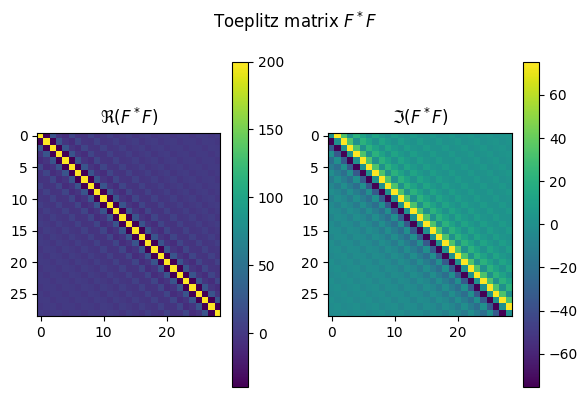

In [19]:
# side by side toeplitz mat real and imag
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
im1 = ax1.imshow(toeplitz_mat.real)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$\Re(F^*F)$')
im2 = ax2.imshow(toeplitz_mat.imag)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$\Im(F^*F)$')
plt.suptitle(r'Toeplitz matrix $F^*F$')
plt.tight_layout()
plt.show()


Compute the convolution vector given a Toeplitz matrix.


Concat:
- first column of toeplitz mat (flipped, so we go from -2m to 0)
- then first row of toeplitz mat (excluding first element, so 1 to 2m)



In [20]:
# scott: going from bottom left to top right corners of the Toeplitz matrix
v_from_toeplitz = torch.cat([toeplitz_mat[:,0].flip(0), toeplitz_mat[0,1:]]) # flipping just the first column so that 0 interval is in the middle 

In [21]:
m = (mtot - 1) // 2 # little m; mtot = 2m + 1
assert v_from_toeplitz.shape[0] == 4*m + 1, "v_from_toeplitz should have length 4m + 1"

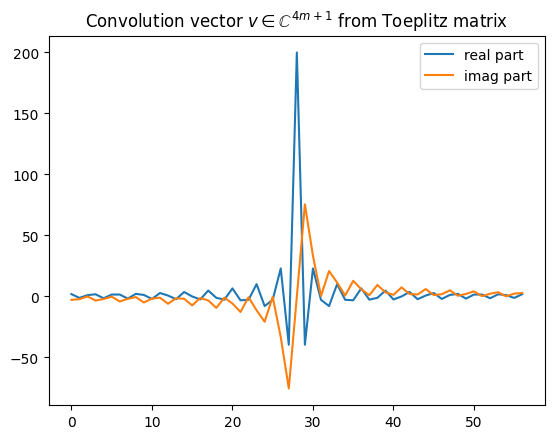

In [22]:
plt.plot(v_from_toeplitz.real, label="real part")
plt.plot(v_from_toeplitz.imag, label="imag part")
plt.legend()
plt.title(r'Convolution vector $v \in \mathbb{C}^{4m+1}$ from Toeplitz matrix')
plt.show()

Now multiply a a random vector by the Toeplitz matrix and compare with the convolution vector (which we will do elementwise with FFT convolution).

In [23]:
random_vector = torch.randn(mtot, dtype=torch.complex128)

In [24]:
random_vector 

tensor([ 0.1127-0.3032j,  1.4074-0.8983j,  0.3854-0.1650j, -1.1122+0.4445j,
        -0.0854-0.2518j,  0.1199-0.2419j, -1.2747-0.5669j, -0.3471+0.3271j,
        -0.8053+0.1604j, -0.0799-0.1667j,  0.0553-0.1393j,  0.9632+0.0082j,
         0.7650-0.2933j,  0.9414+0.7489j,  0.2277-0.5554j, -0.2884+0.3848j,
        -0.3807-0.5738j,  0.2397-0.1071j, -1.4249+0.5622j,  0.7999-0.2955j,
         0.0743-0.6476j, -0.7368+1.4859j,  1.5297+0.4014j, -0.3865-0.6964j,
        -0.1362-1.3189j,  1.4531+0.6298j, -0.4887-0.7960j, -0.0068+0.0429j,
         0.3772-0.6492j], dtype=torch.complex128)

In [25]:
toeplitz_mat.dtype

torch.complex128

In [26]:
toeplitz_times_random_vector = toeplitz_mat @ random_vector

In [27]:
convolution_output = FFTConv1d(v_from_toeplitz.flip(0), random_vector)() # flip is needed also in the FFT. 

In [29]:
# they should be the same
assert torch.allclose(toeplitz_times_random_vector, convolution_output, rtol=1e-5, atol=1e-16), "toeplitz_times_random_vector and convolution_output are not the same"


In [44]:
a= torch.arange(3)
b= torch.arange(4)
outer_result = torch.outer(a, b)
print(outer_result)

tensor([[0, 0, 0, 0],
        [0, 1, 2, 3],
        [0, 2, 4, 6]])


In [32]:
def compute_convolution_vector_vectorized(m: int, x: torch.Tensor, h: float) -> torch.Tensor:
    """
    Vectorized implementation of compute_convolution_vector
    Args:
        m (int): Half number of nodes (mtot = 2m + 1)
        x (torch.Tensor): Input points
        h (float): Grid spacing
    Returns:
        torch.Tensor: Convolution vector of shape (4m+1,)
    """
    j_indices = torch.arange(-2*m, 2*m + 1).to(dtype=torch.complex128) # j = -2m, ..., 2m
    exponents = 2 * torch.pi * 1j * h * torch.outer(j_indices, x).to(dtype=torch.complex128)
    v = torch.sum(torch.exp(exponents), dim=1).conj()
    # TODO: the final conjugation was necessary to make everything match, but I am not sure it matches the equation
    return v, j_indices

In [33]:
v_manual, indices = compute_convolution_vector_vectorized(m=m, x=x, h=h)

In [34]:
assert torch.allclose(v_manual.flip(0), v_from_toeplitz, rtol=1e-4, atol=1e-12), "v_manual and v_from_toeplitz are not the same"


In [35]:
# print the min and max values of the difference
print(f"Min difference: {torch.min(torch.abs(v_manual.to(dtype=torch.complex128).flip(0) - v_from_toeplitz.to(dtype=torch.complex128)))}")
print(f"Max difference: {torch.max(torch.abs(v_manual.to(dtype=torch.complex128).flip(0) - v_from_toeplitz.to(dtype=torch.complex128)))}")


Min difference: 9.211275653342454e-07
Max difference: 3.925131295850928e-05


In [46]:
from cg import ConjugateGradients